In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time

In [2]:
dataset = pd.read_csv('voice.csv')
print 'total rows: ' + str(dataset.shape[0])
print 'total columns: ' + str(dataset.shape[1])
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

total rows: 3168
total columns: 21


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
238,0.117323,0.078195,0.108297,0.047134,0.192465,0.145331,2.573538,14.185274,0.945118,0.651739,...,0.117323,0.114503,0.015920,0.266667,0.078906,0.007812,0.250000,0.242188,0.261860,male
155,0.174298,0.072623,0.178300,0.103648,0.246028,0.142380,15.553404,331.377480,0.925300,0.523066,...,0.174298,0.089305,0.015826,0.246154,0.164885,0.070312,0.828125,0.757812,0.111583,male
804,0.173483,0.058914,0.183241,0.119797,0.227899,0.108101,1.280841,4.269679,0.926355,0.443394,...,0.173483,0.095161,0.015717,0.163265,0.597470,0.007812,3.468750,3.460938,0.287246,male
1672,0.130742,0.086539,0.118831,0.051944,0.207065,0.155121,0.848884,3.513097,0.975041,0.798290,...,0.130742,0.179920,0.018824,0.275862,0.301663,0.007812,1.117188,1.109375,0.266432,female
2672,0.190971,0.039801,0.187163,0.160851,0.212979,0.052128,1.702592,5.625780,0.869996,0.217293,...,0.190971,0.153193,0.048193,0.277457,1.183333,0.023438,7.523438,7.500000,0.092543,female


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
x_data = dataset.iloc[:, :-1].values.astype(np.float32)
x_data = StandardScaler().fit_transform(x_data)
y_datalabel = dataset.iloc[:, -1]
y_data = LabelEncoder().fit_transform(dataset.ix[:, -1])

onehot = np.zeros((y_data.shape[0], np.unique(y_data).shape[0]))
for i in xrange(y_data.shape[0]):
    onehot[i, y_data[i]] = 1.0
    
x_train, x_test, y_train, y_test, _, y_test_label = train_test_split(x_data, onehot, y_data, test_size = 0.2)

print np.unique(y_datalabel)
print np.unique(y_data)

['female' 'male']
[0 1]


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
size_layer_first = 256
size_layer_second = 128
learning_rate = 0.001
beta = 0.00005

X = tf.placeholder("float", [None, x_train.shape[1]])
Y = tf.placeholder("float", [None, np.unique(y_data).shape[0]])
layer1 = tf.Variable(tf.random_normal([x_train.shape[1], size_layer_first]))
layer2 = tf.Variable(tf.random_normal([size_layer_first, size_layer_first]))
layer3 = tf.Variable(tf.random_normal([size_layer_first, size_layer_second]))
layer4 = tf.Variable(tf.random_normal([size_layer_second, np.unique(y_data).shape[0]]))

bias1 = tf.Variable(tf.random_normal([size_layer_first], stddev = 0.1))
bias2 = tf.Variable(tf.random_normal([size_layer_first], stddev = 0.1))
bias3 = tf.Variable(tf.random_normal([size_layer_second], stddev = 0.1))
bias4 = tf.Variable(tf.random_normal([np.unique(y_data).shape[0]], stddev = 0.1))

hidden1 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(X, layer1) + bias1), 0.3)
hidden2 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(hidden1, layer2) + bias2), 0.3)
hidden3 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(hidden2, layer3) + bias3), 0.3)
hidden4 = tf.matmul(hidden3, layer4) + bias4

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = hidden4))
loss += tf.nn.l2_loss(layer1) * beta + tf.nn.l2_loss(layer2) * beta + tf.nn.l2_loss(layer3) * beta + tf.nn.l2_loss(layer4) * beta

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(hidden4, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

BATCH_SIZE = 32

EPOCH, LOSS, ACC = [], [], []
for i in xrange(500):
    last = time.time()
    EPOCH.append(i)
    TOTAL_LOSS, ACCURACY = 0, 0
    for n in xrange(0, (x_train.shape[0] // BATCH_SIZE) * BATCH_SIZE, BATCH_SIZE):
        cost, _ = sess.run([loss, optimizer], feed_dict = {X : x_train[n: n + BATCH_SIZE, :], Y : y_train[n: n + BATCH_SIZE, :]})
        ACCURACY += sess.run(accuracy, feed_dict = {X : x_train[n: n + BATCH_SIZE, :], Y : y_train[n: n + BATCH_SIZE, :]})
        TOTAL_LOSS += cost
    
    TOTAL_LOSS /= (x_train.shape[0] // BATCH_SIZE)
    ACCURACY /= (x_train.shape[0] // BATCH_SIZE)
    LOSS.append(TOTAL_LOSS); ACC.append(ACCURACY)
    timetaken = (time.time() - last) / ((x_train.shape[0] // BATCH_SIZE) * 1.0)
    if (i + 1) % 50 == 0:
        print 'epoch: ' + str(i + 1) + ', loss: ' + str(TOTAL_LOSS) + ', accuracy: ' + str(ACCURACY) + ', s / batch: ' + str(timetaken)

epoch: 50, loss: 3.06304372413, accuracy: 0.678401898734, s / batch: 0.00472506390342
epoch: 100, loss: 2.32132978379, accuracy: 0.857990506329, s / batch: 0.00278586073767
epoch: 150, loss: 1.41184573536, accuracy: 0.95292721519, s / batch: 0.00293815286854
epoch: 200, loss: 0.756773640838, accuracy: 0.967563291139, s / batch: 0.00335739232317
epoch: 250, loss: 0.387232783474, accuracy: 0.972310126582, s / batch: 0.00281164615969
epoch: 300, loss: 0.221364457773, accuracy: 0.976265822785, s / batch: 0.00306655787214
epoch: 350, loss: 0.158033312876, accuracy: 0.976265822785, s / batch: 0.00314956978907
epoch: 400, loss: 0.135611997186, accuracy: 0.975474683544, s / batch: 0.00263855728922
epoch: 450, loss: 0.11485385277, accuracy: 0.977056962025, s / batch: 0.00268245346939
epoch: 500, loss: 0.115034607062, accuracy: 0.976265822785, s / batch: 0.00454028950462


In [11]:
from sklearn import metrics
testing_acc, logits = sess.run([accuracy, tf.cast(tf.argmax(hidden4, 1), tf.int32)], feed_dict = {X : x_test, Y : y_test})
print 'testing accuracy: ' + str(testing_acc)
print(metrics.classification_report(y_test_label, logits, target_names = ['female', 'male']))

testing accuracy: 0.968454
             precision    recall  f1-score   support

     female       0.96      0.97      0.97       319
       male       0.97      0.96      0.97       315

avg / total       0.97      0.97      0.97       634



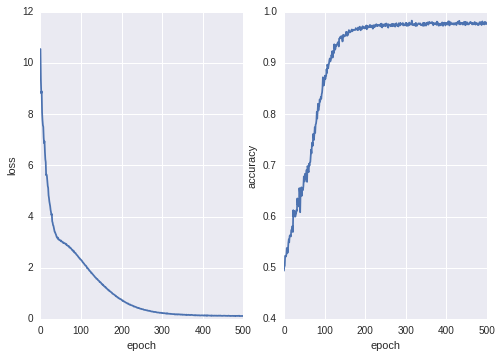

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOSS)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACC)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()